In [13]:
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import torchvision.transforms as transforms
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
import matplotlib.pyplot as plt

In [2]:
USE_CUDA =  True if torch.cuda.is_available() else False

In [9]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

trainset = torchvision.datasets.CIFAR10('/cifar10/', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,shuffle=True, num_workers=2, batch_size = 10)

testset = torchvision.datasets.CIFAR10('/cifar10/', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,shuffle=False, num_workers=2, batch_size = 100)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, num_routes=32 * 6 * 6):
        super(PrimaryCaps, self).__init__()
        self.num_routes = num_routes
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)

        u = u.view(x.size(0), self.num_routes, -1)
        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        denom = ((1. + squared_norm) * torch.sqrt(squared_norm))
        if torch.isinf(denom).sum().item()>0:
            output_tensor = input_tensor / torch.sqrt(squared_norm)
        else:
            output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W,x)

        b_ij = torch.zeros(1, self.num_routes, self.num_capsules, 1)
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        denom = ((1. + squared_norm) * torch.sqrt(squared_norm))
        if torch.isinf(denom).sum().item()>0:
            output_tensor = input_tensor / torch.sqrt(squared_norm)
        else:
            output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor


class CapsNet(nn.Module):
    def __init__(self, config=None):
        super(CapsNet, self).__init__()
        if config:
            self.conv_layer = ConvLayer(config.cnn_in_channels, config.cnn_out_channels, config.cnn_kernel_size)
            self.primary_capsules = PrimaryCaps(config.pc_num_capsules, config.pc_in_channels, config.pc_out_channels,
                                                config.pc_kernel_size, config.pc_num_routes)
            self.digit_capsules = DigitCaps(config.dc_num_capsules, config.dc_num_routes, config.dc_in_channels,
                                            config.dc_out_channels)
        else:
            self.conv_layer = ConvLayer()
            self.primary_capsules = PrimaryCaps()
            self.digit_capsules = DigitCaps()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        return output

In [5]:
class Config_1:
    def __init__(self, in_channels):
            # CNN (cnn)
            self.cnn_in_channels = in_channels
            self.cnn_out_channels = 256
            self.cnn_kernel_size = 3

            # Primary Capsule (pc)
            self.pc_num_capsules = 8
            self.pc_in_channels = 256
            self.pc_out_channels = 32
            self.pc_kernel_size = 3
            self.pc_num_routes = 32 * 11 * 11

            # Digit Capsule (dc)
            self.dc_num_capsules = 10
            self.dc_num_routes = 32 * 11 * 11
            self.dc_in_channels = 8
            self.dc_out_channels = 1

class Config_2:
    def __init__(self, in_channels):
            # CNN (cnn)
            self.cnn_in_channels = in_channels
            self.cnn_out_channels = 256
            self.cnn_kernel_size = 3

            # Primary Capsule (pc)
            self.pc_num_capsules = 8
            self.pc_in_channels = 256
            self.pc_out_channels = 32
            self.pc_kernel_size = 3
            self.pc_num_routes = 32 * 8 * 8

            # Digit Capsule (dc)
            self.dc_num_capsules = 10
            self.dc_num_routes = 32 * 8 * 8
            self.dc_in_channels = 8
            self.dc_out_channels = 1

class Config_3:
    def __init__(self, in_channels):
            # CNN (cnn)
            self.cnn_in_channels = in_channels
            self.cnn_out_channels = 256
            self.cnn_kernel_size = 3

            # Primary Capsule (pc)
            self.pc_num_capsules = 8
            self.pc_in_channels = 256
            self.pc_out_channels = 32
            self.pc_kernel_size = 3
            self.pc_num_routes = 32 * 5 * 5

            # Digit Capsule (dc)
            self.dc_num_capsules = 10
            self.dc_num_routes = 32 * 5 * 5
            self.dc_in_channels = 8
            self.dc_out_channels = 1

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size = (3,3))
        self.conv2 = nn.Conv2d(32,48,kernel_size = (3,3))
        self.conv3 = nn.Conv2d(48,64,kernel_size = (3,3))
        self.conv4 = nn.Conv2d(64,80,kernel_size = (3,3))
        self.conv5 = nn.Conv2d(80,96,kernel_size = (3,3))
        self.conv6 = nn.Conv2d(96,112,kernel_size = (3,3))
        self.conv7 = nn.Conv2d(112,128,kernel_size = (3,3))
        self.conv8 = nn.Conv2d(128,144,kernel_size = (3,3))
        self.conv9 = nn.Conv2d(144,160,kernel_size = (3,3))
        self.caps_a = CapsNet(Config_1(64))
        self.caps_b = CapsNet(Config_2(112))
        self.caps_c = CapsNet(Config_3(160))
        self.merge_weight1= nn.Parameter(torch.randn(1))
        self.merge_weight2= nn.Parameter(torch.randn(1))
        self.merge_weight3= nn.Parameter(torch.randn(1))
        self.relu = nn.ReLU()
        self.batchnorm_branch1 = nn.BatchNorm2d(64)
        self.batchnorm_branch2 = nn.BatchNorm2d(112)
        self.batchnorm_branch3 = nn.BatchNorm2d(160)
        self.upsample_conv1 = nn.Conv2d(3,48,kernel_size=(5,5))
        self.upsample_conv2 = nn.Conv2d(48,80,kernel_size=(5,5))
        self.upsample_conv3 = nn.Conv2d(80,112,kernel_size=(5,5))
        self.upsample_conv4 = nn.Conv2d(112,144,kernel_size=(5,5))

        self.k1= nn.Parameter(torch.randn(1))
        self.k2= nn.Parameter(torch.randn(1))
        self.k3= nn.Parameter(torch.randn(1))
        self.k4= nn.Parameter(torch.randn(1))
        
    def forward(self,x):
        branch1 = self.conv1(x)
        branch1 = self.relu(branch1)
        branch1 = self.conv2(branch1)
        branch1 = self.relu(branch1)

        branch1 += self.k1 * self.upsample_conv1(x)
        x1 = branch1.clone()
        
        branch1 = self.conv3(branch1)
        branch1 = self.relu(branch1)
        branch2 = self.conv4(branch1)
        branch2 = self.relu(branch2)

        branch2 += self.k2 * self.upsample_conv2(x1)
        x1 = branch2.clone()

        branch2 = self.conv5(branch2)
        branch2 = self.relu(branch2)
        branch2 = self.conv6(branch2)
        branch2 = self.relu(branch2)

        branch2 += self.k3 * self.upsample_conv3(x1)
        x1 = branch2.clone()

        branch3 = self.conv7(branch2)
        branch3 = self.relu(branch3)
        branch3 = self.conv8(branch3)
        branch3 = self.relu(branch3)

        branch3 += self.k4 * self.upsample_conv4(x1)

        branch3 = self.conv9(branch3)
        branch3 = self.relu(branch3)

        #Batch Normalizing 
        branch1 = self.batchnorm_branch1(branch1)
        branch2 = self.batchnorm_branch2(branch2)
        branch3 = self.batchnorm_branch3(branch3)

        branch1_out = self.caps_a(branch1)
        branch2_out = self.caps_b(branch2)
        branch3_out = self.caps_c(branch3)

        branch1_out = torch.sqrt((branch1_out ** 2).sum(dim=2, keepdim=True)).view(-1,10)
        branch2_out = torch.sqrt((branch2_out ** 2).sum(dim=2, keepdim=True)).view(-1,10)
        branch3_out = torch.sqrt((branch3_out ** 2).sum(dim=2, keepdim=True)).view(-1,10)
        
        out1 = self.merge_weight1 * branch1_out
        out2 = self.merge_weight1 * branch2_out
        out3 = self.merge_weight1 * branch3_out
        stack = torch.stack([out1,out3,out3],dim = 0)
        summed = torch.sum(stack,dim = 0)
        return summed

In [8]:
net = torch.load('modified_capsnet_cifar10.pt')

F:\Anaconda\Anaconda3\envs\deep\lib\site-packages\torch\serialization.py:559: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
F:\Anaconda\Anaconda3\envs\deep\lib\site-packages\torch\serialization.py:559: UserWarning: Couldn't retrieve source code for container of type CapsNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
F:\Anaconda\Anaconda3\envs\deep\lib\site-packages\torch\serialization.py:559: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
F:\Anaconda\Anaconda3\envs\deep\lib\site-packages\torch\serialization.py:559: UserWarning: Couldn't retrieve source code for container of type PrimaryCaps. It won't be checked for correctness upon loading.
 

In [10]:
predict = []
true = []
if USE_CUDA:
    net = net.cuda()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if USE_CUDA:
            images = images.cuda()
            net = net.cuda()
        outputs = net(images)
        predicted = torch.argmax(outputs.data, 1)
        predict.extend(predicted.tolist())
        true.extend(labels.tolist())

In [11]:
print("Accuracy : ",accuracy_score(true,predict))
print("Precision Score",np.mean(precision_score(true,predict,average=None)))
print("Recall Score",np.mean(recall_score(true,predict,average=None)))
print("F1 Score",np.mean(f1_score(true,predict,average=None)))

Accuracy :  0.757
Precision Score 0.7691044729832307
Recall Score 0.757
F1 Score 0.7549208604587312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

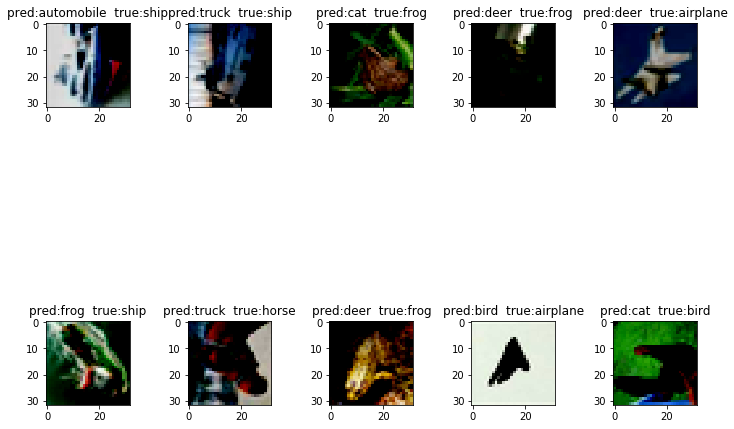

In [17]:
testloader = torch.utils.data.DataLoader(testset,shuffle=False, num_workers=2, batch_size = 1)
wrong = 0
row = 2
col = 5
figure = plt.figure(figsize=(10, 10))
with torch.no_grad():
    for data in testloader:
        image,label = data
        image = image.cuda()
        net = net.cuda()
        pred = net(image)
        pred = torch.argmax(pred.data, 1)
        if pred.item() != label.item():
            wrong += 1
            img = image[0].cpu().numpy()
            img = img.transpose(2,1,0)
            plt.subplot(row,col,wrong)
            plt.title("pred:{}  true:{}".format(cifar10_labels[pred.item()],cifar10_labels[label.item()]))
            plt.imshow(img)
            if wrong > 9:
                break
figure.tight_layout(pad=0.6)

In [15]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

4568055